# Text Data Gathering and cleaning by Python

## Introduction

In this part, I used Twitter api and tweepy to collect tweets text data. Then I used a pipeline to clean the text data set. In the pipeline, I used regular expressions to match the words and removed stop words. Then I plot a wordcloud to show the keywords of my data. Next I did the sensitive analysis to add a label for the data for further model input. And finally save the data into a csv file for further analysis.

## Theory

**Twitter api**

The Twitter API is a set of programmatic endpoints that can be used to understand or build the conversation on Twitter. This API allows you to find and retrieve, engage with, or create a variety of different resources including the following: Tweets. Users.

**tweepy**

Tweepy is an open source Python package that gives you a very convenient way to access the Twitter API with Python. Tweepy includes a set of classes and methods that represent Twitter's models and API endpoints, and it transparently handles various implementation details, such as: Data encoding and decoding.

**Stop words**

You should remove these tokens only if they don't add any new information for your problem. Classification problems normally don't need stop words because it's possible to talk about the general idea of a text even if you remove stop words from it.

**wordcloud**

Word clouds or tag clouds are graphical representations of word frequency that give greater prominence to words that appear more frequently in a source text. The larger the word in the visual the more common the word was in the document(s).

**Sensitive Analysis**

Sensitivity Analysis is a tool used in financial modeling to analyze how the different values of a set of independent variables affect a specific dependent variable under certain specific conditions.

## Methods

In [1]:
import pandas as pd
import os
import time
import requests
import json
import csv
from tqdm import tqdm

import tweepy

import requests
import pandas as pd
import os

In [2]:
consumer_key = "inZ89PddRMaRQwE6GVqA3Q41O"
consumer_secret = "9MXxneTgvjgNxLgRWwZDto5SkadnHw5JkFcGKuRPqwMHU61ZMM"
access_token = "1555013004927705088-42uhpeSplVieHyeh7iWAm5Tk7uRu5G"
access_token_secret = "jERIeAGcoKGEju47LndLdypLBkxwzRzdtMHqDcs4cTO24"
bearer_token = "AAAAAAAAAAAAAAAAAAAAAHxTfgEAAAAAFoqGo6ZQ%2BYdXOC8pDIvIgRX0jJM%3DCnfeZi86Klf8HPAGUap5AoUjQN754ki2jjomd4ZhTLtcwGpg6q"

Get credit related data from Twitter using Twitter api.

In [3]:
query = "credit"
client = tweepy.Client(bearer_token= bearer_token)
tweets = tweepy.Paginator(client.search_recent_tweets, query = query, tweet_fields = ['text','author_id','created_at','lang'], max_results = 100).flatten(limit=250)
result = [[tweet.text, tweet.author_id,tweet.created_at,tweet.lang] for tweet in tweets]


In [4]:
text = [x[0] for x in result]

In [5]:
len(text)

250

Use a pipeline to remove stopwords and illegal symbols and emojis to make text data clean.

In [6]:
import re
from tqdm import tqdm
from typing import List

import spacy
from spacy.language import Language

pipeline_name = '2020ElectionTweets'


def camel_case_split(str):
    """ This function turns in #Biden2020 into Biden 2020 """
    return " ".join([wrd for wrd in re.findall(r'[A-Z](?:[a-z]+|[A-Z]*(?=[A-Z]|$))', str)])


@Language.component(pipeline_name)
def preprocess(doc):
    doc = [token for token in doc if not token.is_punct]
    # doc = [token for token in doc if not token.is_stop]
    doc = [token.text.lower().strip() for token in doc]
    doc = [token for token in doc if 0 < len(token) <= 12]
    return " ".join(doc)


class Pipeline:
    
    
    email_re = r"""(?:[a-z0-9!#$%&'*+/=?^_`{|}~-]+(?:\.[a-z0-9!#$%&'*+/=?^_`{|}~-]+)
    *|"(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21\x23-\x5b\x5d-\x7f]
    |\\[\x01-\x09\x0b\x0c\x0e-\x7f])*")@(?:(?:[a-z0-9](?:[a-z0-9-]*[a-z0-9])?\.)+[a-z0-9]
    (?:[a-z0-9-]*[a-z0-9])?|\[(?:(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}
    (?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?|[a-z0-9-]*[a-z0-9]:
    (?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21-\x5a\x53-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])+)\])"""
    # replace = [ (pattern-to-replace, replacement),  ...]
    replace = [
        ("<[^>]*>", " "),
        (email_re, " "),                           # Matches emails
        (r"(?<=\d),(?=\d)", ""),                   # Remove commas in numbers
        (r"\d+", " "),                             # Map digits to special token <numbr>
        (r"[*\^\.$&@<>,\-/+{|}=?#:;'\"\[\]]", ""), # Punctuation and other junk
        (r"[\n\t\r]", " "),                        # Removes newlines, tabs, creturn
        (r"[^\x00-\x7F]+", ""),                    # Removes non-ascii chars
        (r"\\+", " "),                             # Removes double-backslashs
        (r"\s+n\s+", " "),                         # 'n' leftover from \\n
        (r"\s+", " ")                              # Strips extra whitespace
    ]
    
    def __init__(self):
        self.pipeline = spacy.load('en_core_web_sm')
        self.pipeline.add_pipe(pipeline_name);
        
    def __call__(self, *args, **kwargs):
        return self.transform(*args, **kwargs)

    def transform(self, doc: str):
        for repl in self.replace:
            doc = re.sub(repl[0], repl[1], doc)
        doc = camel_case_split(doc)
        return self.pipeline(doc)
    
pipeline = Pipeline();

In [7]:
from tqdm import tqdm

with tqdm(total=250) as bar:
    for i, ts in enumerate(zip(text)):
        text[i] = pipeline(str(ts))
        bar.update()

100%|██████████| 250/250 [00:03<00:00, 80.20it/s]


Plot a wordcloud to see some main keywords of the dataset.

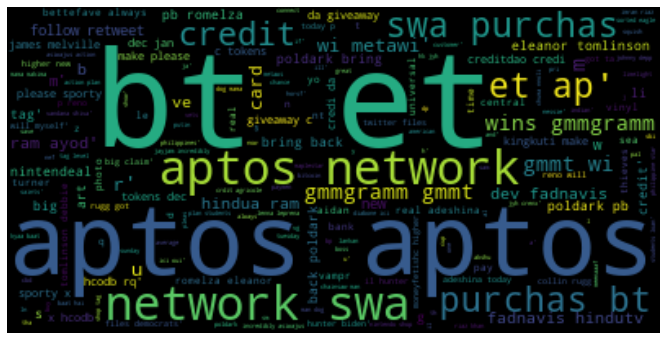

In [8]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
wordcloud = WordCloud().generate(str(text))
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Convert it into a data frame.

In [9]:
txt = pd.DataFrame(text)
txt.columns = ['text']

In [10]:
txt

,text
0,questions ask before selecting credit card mer...
1,r bettefave always poldark sunday poldark brin...
2,r real adeshina today p reno will myself
3,r were aptos aptos network swa purchas bt et ap
4,r dev fadnavis hindutv he hindua ram ayod
...,...
245,megan the oracle im we mercedes
246,magik toasterr raphael n mc clintock memphis o...
247,r wednesdays jenna ortega shohei ohtani
248,r


Use nltk tool to add label for each text data, including positive, negative and neutral sentiments.

In [11]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download("vader_lexicon")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     c:\Users\wsy\anaconda3\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [12]:
sentiments = SentimentIntensityAnalyzer()
txt["Positive"] = [sentiments.polarity_scores(i)["pos"] for i in txt["text"]]
txt["Negative"] = [sentiments.polarity_scores(i)["neg"] for i in txt["text"]]
txt["Neutral"] = [sentiments.polarity_scores(i)["neu"] for i in txt["text"]]
txt['Compound'] = [sentiments.polarity_scores(i)["compound"] for i in txt["text"]]
txt.head()

,text,Positive,Negative,Neutral,Compound
0,questions ask before selecting credit card mer...,0.271,0.0,0.729,0.3818
1,r bettefave always poldark sunday poldark brin...,0.000,0.0,1.000,0.0000
2,r real adeshina today p reno will myself,0.000,0.0,1.000,0.0000
3,r were aptos aptos network swa purchas bt et ap,0.000,0.0,1.000,0.0000
4,r dev fadnavis hindutv he hindua ram ayod,0.000,0.0,1.000,0.0000


In [13]:
score = txt["Compound"].values
sentiment = []
for i in score:
    if i >= 0.05 :
        sentiment.append('Positive')
    elif i <= -0.05 :
        sentiment.append('Negative')
    else:
        sentiment.append('Neutral')
txt["Sentiment"] = sentiment
txt.head()

,text,Positive,Negative,Neutral,Compound,Sentiment
0,questions ask before selecting credit card mer...,0.271,0.0,0.729,0.3818,Positive
1,r bettefave always poldark sunday poldark brin...,0.000,0.0,1.000,0.0000,Neutral
2,r real adeshina today p reno will myself,0.000,0.0,1.000,0.0000,Neutral
3,r were aptos aptos network swa purchas bt et ap,0.000,0.0,1.000,0.0000,Neutral
4,r dev fadnavis hindutv he hindua ram ayod,0.000,0.0,1.000,0.0000,Neutral


Count the number of each category.

In [14]:
print(txt["Sentiment"].value_counts())

Neutral     162
Positive     74
Negative     14
Name: Sentiment, dtype: int64


Convert string label into number.

In [15]:
txt["sentiment"] = txt["Sentiment"].map({"Neutral": 0, "Positive": 1, "Negative": 2})
txt.head()

,text,Positive,Negative,Neutral,Compound,Sentiment,sentiment
0,questions ask before selecting credit card mer...,0.271,0.0,0.729,0.3818,Positive,1
1,r bettefave always poldark sunday poldark brin...,0.000,0.0,1.000,0.0000,Neutral,0
2,r real adeshina today p reno will myself,0.000,0.0,1.000,0.0000,Neutral,0
3,r were aptos aptos network swa purchas bt et ap,0.000,0.0,1.000,0.0000,Neutral,0
4,r dev fadnavis hindutv he hindua ram ayod,0.000,0.0,1.000,0.0000,Neutral,0


In [16]:
txt.to_csv("clean_text_data.csv")

## Result

In this part, I used Twitter api and tweepy to collect tweets text data. Then I used a pipeline to clean the text data set. In the pipeline, I used regular expressions to match the words and removed stop words. Then I plot a wordcloud to show the keywords of my data. Next I did the sensitive analysis to add a label for the data for further model input. And finally save the data into a csv file for further analysis.

## Conclusions

Text cleaning is task-specific and one needs to have a strong idea about what they want their end result to be and even review the data to see what exactly they can achieve.

Here I summarized some steps to clean text data:

**Most common methods for Cleaning the Data**

* Lowecasing the data
* Removing Puncuatations
* Removing Numbers
* Removing extra space
* Replacing the repetitions of punctations
* Removing Emojis
* Removing emoticons
* Removing Contractions

But we should keep in mind that there is actually no fixed way to clean a data set. All we need to do is to find a suitable method to clean your own data set.